In [ ]:
!pip install pmlb
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

     |████████████████████████████████| 276kB 9.1MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=3c081f0eeb70400ed5166200d9f8293bf732d3a50a4c729b7d144bdc70ef1ac0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
     |████████████████████████████████| 1.1MB 8.2MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling te

In [ ]:
from pmlb import fetch_data
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from sklearn.ensemble import BaggingRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

# Homework 2 - part II

**First: go to Runtime > Change runtime type > select GPU or TPU to accelerate the computations**

This part of the homework of more about "the art of machine learning", where you will have to play with hyperparameters to get a good result. 

For this part of the homework you can work with a classmate. If so, write it here:

"I worked with ________________"

Here, we will work with some real data, where we will try to predict the time that it takes for a car to get from 0 to 60 miles per hour (96 km/h) in seconds, based on the following attributes:
- miles per gallon: how many miles can you drive the car with one gallon of gasoline.
- cylinders of the engine
- size of the engine
- horsepower
- weight
- year of fabrication. The cars are old, between 1971 and 1983.

You can browse the dataset [here](https://epistasislab.github.io/penn-ml-benchmarks/profile/cars.html)

In [ ]:
data = fetch_data("cars")
data.describe()

,MPG,cylinders,cubicInches,horsepower,weightLbs,time-to-sixty,year,brand,target
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.413265,104.469388,2977.584184,15.681122,1976.979592,13.323980,1.451531
std,7.805007,1.705783,104.642823,38.491160,849.402560,2.761232,3.683737,8.558786,0.772082
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,1971.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,14.000000,1974.000000,6.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,16.000000,1977.000000,11.000000,2.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.000000,1980.000000,21.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,25.000000,1983.000000,29.000000,2.000000


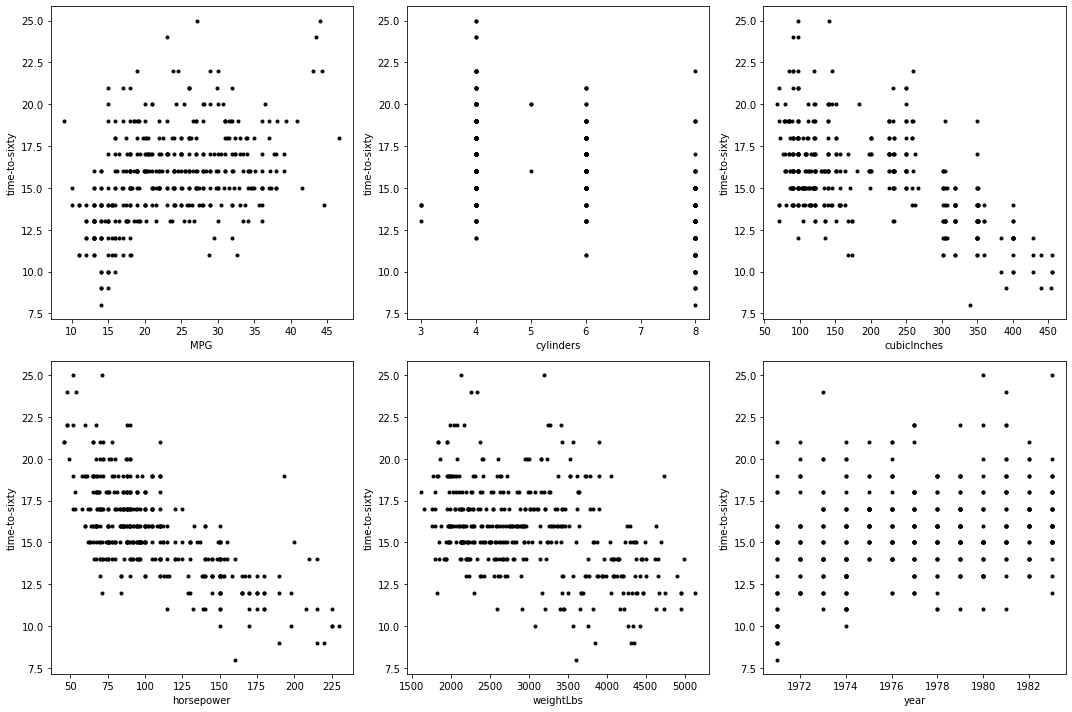

In [ ]:
fields = ['MPG', 'cylinders', 'cubicInches', 'horsepower', 'weightLbs', 'year']

fig = plt.figure()
fig.set_size_inches((15,10))
for i, field in enumerate(fields):
  plt.subplot(2, 3, i + 1)
  plt.plot(data[field], data['time-to-sixty'], 'k.')
  plt.xlabel(field)
  plt.ylabel('time-to-sixty')

plt.tight_layout()

In [ ]:
Y = data['time-to-sixty'][:,None]
X = data[['MPG', 'cylinders', 'cubicInches', 'horsepower', 'weightLbs', 'year']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


A key step to train a neural network (and many other machine learning algorithms) is to normalize the data in a way that both the input and the output will have zero mean and variance equal to one:

In [ ]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu


X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

Now, we will split the data into train, validation and test sets. Note that we can use the validation set to make decisions about the parameters, but the performance will be evaluated with the test set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0], 'validation samples', X_val.shape[0], 'test samples:', X_test.shape[0])

training samples: 235 validation samples 59 test samples: 98


## Problem 1 [25 points]

Tune the hyperparameters until you meet the two following conditions:
1. The mean squared error on the test set is less than 0.23.
2. The mean squared error in the training set is lower than in the test set. Otherwise, your neural network would be overfitting the test set, which is worse than overfitting the training set, because it is smaller.

Some considerations:
- You can change all the hyperparameters, width, depth, optimizer, activation function, learning rate.
- Feel free to add regularization strategies. [See here](https://colab.research.google.com/drive/1I6l1kU8YhCuAR8fLYBZI5QVK8-o6hLnl?usp=sharing) for the notebook with regularization examples.
- The only strategy that is not allowed is to use early stopping with the test set. We have the validation set for that. Also, manually tunning the number of epochs to do early stopping on the test set is not allowed. This will be easy to notice.
- Feel free to automate the parameter search process.

## Problem 2 [5 points]
Comment why is not possible to achieve zero error both in the traning and test sets and relate it to a concept we learned in "Introduction to machine learning" chapter.

### Nos quedamos finalmente con un modelo que utiliza regularización con $\alpha = 0.004$.

In [ ]:
width = 13
depth = 3
L2 = 0.004


net_input = Input(shape=(Xn.shape[1],),name='input')

net_output = Sequential([Dense(width, 'relu', kernel_regularizer=regularizers.l2(L2))]*(depth - 1) + [Dense(1, 'linear', kernel_regularizer=regularizers.l2(L2))], name = 'base_NN')(net_input)

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False, leave_overall_progress = True)

history = model.fit(X_train, y_train, epochs=1500, batch_size = 32, validation_data= (X_val, y_val), callbacks = [tqdm_callback], verbose = 0)

MSE test: 0.22726885913740158
MSE train: 0.21543879105072275
MSE train < MSE test? True
MSE test < 0.23? True


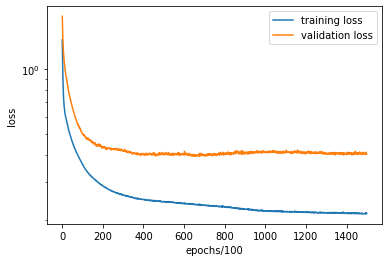

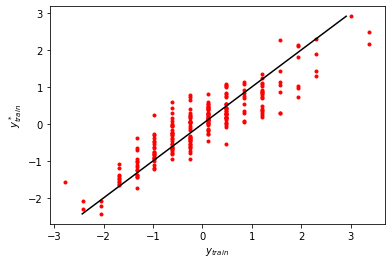

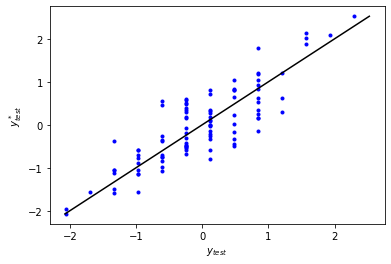

In [ ]:
plt.plot(history.history['mean_squared_error'], label = 'training loss')
plt.plot(history.history['val_mean_squared_error'], label = 'validation loss')
plt.yscale('log')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs/100')

y_star_train = model.predict(X_train)
y_star_test = model.predict(X_test)
plt.figure()
plt.plot(y_train, y_star_train, 'r.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')
plt.figure()
plt.plot(y_test, y_star_test, 'b.')
plt.plot([y_star_test.min(), y_star_test.max()], [y_star_test.min(), y_star_test.max()], 'k')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')

MSE_test = np.average((y_star_test - y_test)**2)
MSE_train = np.average((y_star_train - y_train)**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)
print("MSE train < MSE test?", MSE_train < MSE_test)
print("MSE test < 0.23?", MSE_test < 0.23)

### Observando los últimos dos gráficos se puede observar un buen ajuste de los datos en los datos de entrenamiento y test, pues los puntos se encuentran cercanos a la diagonal.

## Respuesta Pregunta 2:

#### Como hemos visto en clases, es imposible que ambos errores (entrenamiento y set) sean cero, pues si el error de entrenamiento se hace cero, esto implicará un modelo que no es capaz de generalizar los datos, pues este capturó y/o aprendió también el ruido de los datos (overfitting), esto producirá en consecuencia que el error de test incremente y en particular que sea distinto de cero.

#### Otra forma de verlo, aunque está intrínsecamente relacionada a la explicación anterior es utilizando el concepto de Variance-bias trade-off. Que el error en el set de entrenamiento se haga cero implica necesariamente una muy alta capacidad del modelo, el cual induce a un aumento en la varianza debido a la captura del ruido de los datos. En consecuencia, estamos en la zona de overfitting y la conclusión será por tanto idéntica a la efectuada en el primer párrafo.
